In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [3]:
# --- Configuration ---
FILE_PATH = "ohtani_stats_2024.csv" # Replace with your actual file path
TARGET_COLUMN = 'target'
TEST_SIZE = 0.2
RANDOM_STATE = 42

# --- Load Data ---
try:
    df = pd.read_csv(FILE_PATH)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {FILE_PATH}")
    # Handle the error appropriately, e.g., exit or prompt user
    exit()

# --- Define Target Variable ---
# Target: 1 if hit (single, double, triple, home_run) or walk, 0 otherwise
positive_events = ['single', 'double', 'triple', 'home_run', 'walk']
df[TARGET_COLUMN] = df['events'].apply(lambda x: 1 if isinstance(x, str) and x.lower() in positive_events else 0)

# --- Feature Engineering ---
# Create 'opponent_team' feature
df['opponent_team'] = df.apply(lambda row: row['away_team'] if row['home_team'] == 'LAD' else row['home_team'], axis=1)

# Select features (Dropping columns not used for training)
# Note: Consider carefully which columns to drop. 'bb_type' might be useful if handled correctly.
features_to_drop = ['events', 'launch_speed', 'launch_angle', 'hit_distance_sc', 'bb_type','home_team', 'away_team', 'target', 'p_throws', TARGET_COLUMN]
X = df.drop(columns=features_to_drop)
y = df[TARGET_COLUMN]

print(f"Initial features: {X.columns.tolist()}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")

# --- Handle Categorical Features ---
# One-Hot Encode nominal features
categorical_cols_ohe = ['pitch_name', 'opponent_team']
X = pd.get_dummies(X, columns=categorical_cols_ohe, dummy_na=False, dtype=int) # dummy_na=False explicitly avoids creating NaN columns

# Label Encode 'pitcher' (assuming high cardinality makes OHE less suitable)
# Using try-except for robustness if 'pitcher' column is missing
try:
    le = LabelEncoder()
    X['pitcher'] = le.fit_transform(X['pitcher'].astype(str)) # Convert to string to handle potential mixed types/NaNs before encoding
    print("Label encoded 'pitcher'.")
except KeyError:
    print("Warning: 'pitcher' column not found for label encoding.")

Data loaded successfully.
Initial features: ['pitcher', 'pitch_name', 'release_speed', 'release_pos_x', 'release_pos_y', 'zone', 'balls', 'strikes', 'outs_when_up', 'inning', 'opponent_team']
Target distribution:
target
0    0.624396
1    0.375604
Name: proportion, dtype: float64
Label encoded 'pitcher'.


In [4]:
X

,pitcher,release_speed,release_pos_x,release_pos_y,zone,balls,strikes,outs_when_up,inning,pitch_name_4-Seam Fastball,...,opponent_team_PHI,opponent_team_PIT,opponent_team_SD,opponent_team_SEA,opponent_team_SF,opponent_team_STL,opponent_team_TB,opponent_team_TEX,opponent_team_TOR,opponent_team_WSH
0,18,83.3,-2.52,54.37,13.0,1,1,0,7,0,...,0,0,0,0,0,0,0,0,0,0
1,18,87.3,-2.74,54.10,13.0,1,2,1,5,0,...,0,0,0,0,0,0,0,0,0,0
2,18,90.4,-2.77,54.20,13.0,0,2,2,3,0,...,0,0,0,0,0,0,0,0,0,0
3,57,89.7,-1.63,54.56,4.0,0,0,1,8,0,...,0,0,0,0,0,0,0,0,0,0
4,18,95.6,-2.76,54.32,5.0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,179,NaN,NaN,NaN,NaN,0,0,1,3,0,...,0,0,0,0,0,0,0,0,0,0
824,59,NaN,NaN,NaN,NaN,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
825,55,NaN,NaN,NaN,NaN,3,0,2,5,0,...,0,0,0,0,0,0,0,0,0,0
826,2,NaN,NaN,NaN,NaN,3,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
y

0      0
1      0
2      0
3      0
4      0
      ..
823    1
824    1
825    1
826    1
827    1
Name: target, Length: 828, dtype: int64

In [6]:
# --- Identify Numerical Features (After OHE) ---
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
print(f"Numerical columns for imputation/scaling: {numerical_cols}")

# --- Handle Missing Numerical Values (Imputation with Mean) ---
# Impute BEFORE splitting
for col in numerical_cols:
    if X[col].isnull().any():
        mean_val = X[col].mean()
        X[col] = X[col].fillna(mean_val)
        print(f"Imputed NaNs in '{col}' with mean ({mean_val:.2f}).")

# Verify no remaining NaNs (optional but recommended)
if X.isnull().sum().sum() > 0:
    print("Warning: Remaining NaNs detected after imputation!")
    print(X.isnull().sum())
else:
    print("No NaNs remaining in features.")

Numerical columns for imputation/scaling: ['pitcher', 'release_speed', 'release_pos_x', 'release_pos_y', 'zone', 'balls', 'strikes', 'outs_when_up', 'inning', 'pitch_name_4-Seam Fastball', 'pitch_name_Changeup', 'pitch_name_Curveball', 'pitch_name_Cutter', 'pitch_name_Knuckle Curve', 'pitch_name_Knuckleball', 'pitch_name_Other', 'pitch_name_Sinker', 'pitch_name_Slider', 'pitch_name_Split-Finger', 'pitch_name_Sweeper', 'opponent_team_ATL', 'opponent_team_AZ', 'opponent_team_BAL', 'opponent_team_BOS', 'opponent_team_CHC', 'opponent_team_CIN', 'opponent_team_CLE', 'opponent_team_COL', 'opponent_team_CWS', 'opponent_team_DET', 'opponent_team_HOU', 'opponent_team_KC', 'opponent_team_LAA', 'opponent_team_MIA', 'opponent_team_MIL', 'opponent_team_MIN', 'opponent_team_NYM', 'opponent_team_NYY', 'opponent_team_OAK', 'opponent_team_PHI', 'opponent_team_PIT', 'opponent_team_SD', 'opponent_team_SEA', 'opponent_team_SF', 'opponent_team_STL', 'opponent_team_TB', 'opponent_team_TEX', 'opponent_team_T

In [7]:
# --- Train/Test Split ---
# Stratify ensures the proportion of target classes is similar in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# --- Scale Numerical Features ---
# Fit scaler ONLY on training data, then transform both train and test
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols]) # Use transform, not fit_transform, on test data

print("Numerical features scaled.")

Training set shape: (662, 49)
Test set shape: (166, 49)
Numerical features scaled.


In [8]:
# --- Define Model Architecture ---
# Incorporating Batch Normalization and L2 Regularization
INPUT_DIM = X_train.shape[1]
L2_REG = 0.001 # Regularization factor

model = models.Sequential([
    layers.Dense(64, kernel_regularizer=l2(L2_REG), input_shape=(INPUT_DIM,)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5), # Dropout helps prevent overfitting

    layers.Dense(32, kernel_regularizer=l2(L2_REG)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid') # Sigmoid for binary classification output
])

# --- Compile Model ---
model.compile(optimizer='adam', # Adam is a common default choice
              loss='binary_crossentropy', # Standard loss for binary classification
              metrics=['accuracy', keras.metrics.AUC(name='auc')]) # Include AUC metric

model.summary() # Print model architecture

C:\Users\tonyg\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,697 (22.25 KB)

 Trainable params: 5,505 (21.50 KB)

 Non-trainable params: 192 (768.00 B)

In [9]:
# --- Training Configuration ---
EPOCHS = 100
BATCH_SIZE = 32
EARLY_STOPPING_PATIENCE = 15 # Increased patience
LR_REDUCTION_PATIENCE = 5

# --- Callbacks ---
# Early Stopping: Stop training if validation loss doesn't improve
early_stopping = EarlyStopping(monitor='val_loss',
                             patience=EARLY_STOPPING_PATIENCE,
                             restore_best_weights=True, # Keep the best model weights found
                             verbose=1)

# Reduce Learning Rate on Plateau: Reduce LR if validation loss stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2, # Reduce LR by a factor of 5
                              patience=LR_REDUCTION_PATIENCE,
                              min_lr=0.00001, # Minimum learning rate
                              verbose=1)

# --- Class Weights (Handle Imbalance) ---
# Calculate weights to give more importance to the minority class during training
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"Calculated class weights: {class_weight_dict}")


# --- Train the Model ---
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr],
                    class_weight=class_weight_dict, # Apply class weights
                    verbose=1) # Set verbose=1 or 2 to see progress

Calculated class weights: {0: 0.801452784503632, 1: 1.3293172690763053}
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4898 - auc: 0.5064 - loss: 0.9732 - val_accuracy: 0.4458 - val_auc: 0.5340 - val_loss: 0.8591 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4437 - auc: 0.4812 - loss: 0.9674 - val_accuracy: 0.4819 - val_auc: 0.5533 - val_loss: 0.8206 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5021 - auc: 0.5013 - loss: 0.9227 - val_accuracy: 0.5361 - val_auc: 0.5716 - val_loss: 0.8009 - learning_rate: 0.0010
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5001 - auc: 0.5139 - loss: 0.9145 - val_accuracy: 0.5723 - val_auc: 0.5819 - val_loss: 0.7861 - learning_rate: 0.0010
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5424 - auc: 0.5764 - loss: 0.8216 - val_accuracy: 0.6024 - val_auc: 0.6049 - val_loss: 0.7698 - learning_rate: 0.0010
Epoch 6/100



--- Test Set Evaluation ---
Test Loss: 0.6666
Test Accuracy: 0.6566
Test AUC: 0.7201
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

--- Classification Report (Threshold=0.5) ---
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       104
           1       0.53      0.63      0.58        62

    accuracy                           0.66       166
   macro avg       0.64      0.65      0.64       166
weighted avg       0.67      0.66      0.66       166



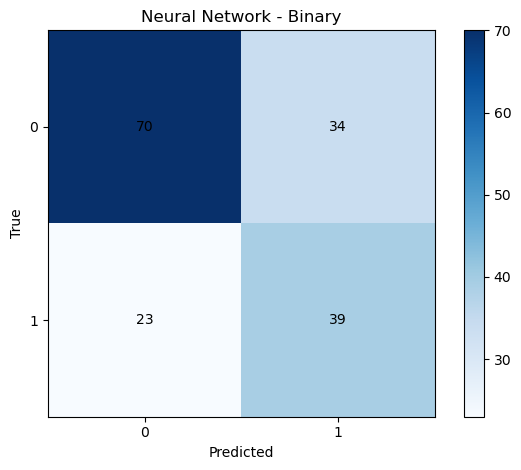

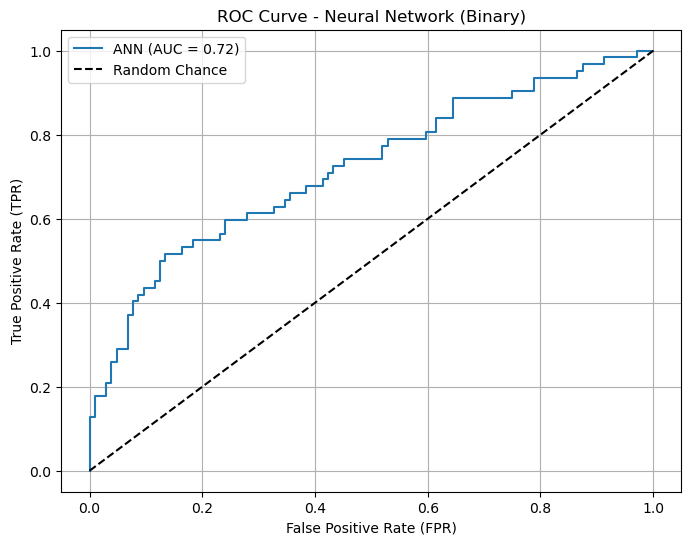


--- Training History ---


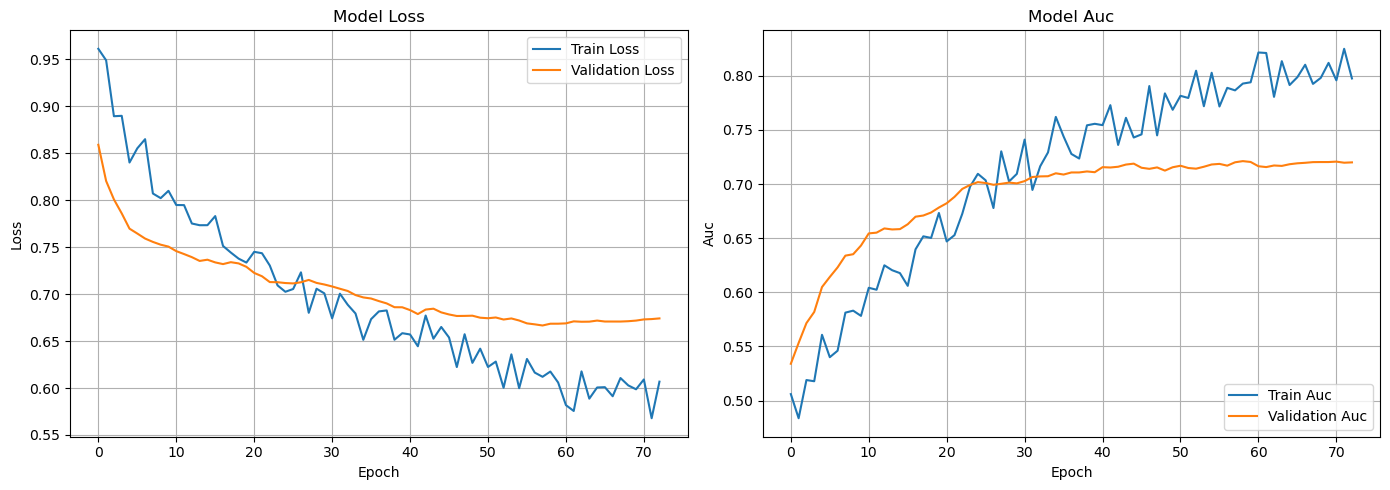

In [14]:
# --- Evaluate on Test Set ---
loss, accuracy, auc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n--- Test Set Evaluation ---")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")

# --- Predictions ---
y_pred_prob = model.predict(X_test)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# --- Classification Report ---
print("\n--- Classification Report (Threshold=0.5) ---")
print(classification_report(y_test, y_pred_binary))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix (matching your other code style)
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Add colorbar
plt.colorbar(im)

# Add labels and title
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Neural Network - Binary')

# Set tick marks and class labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['0', '1'])
ax.set_yticks([0, 1])
ax.set_yticklabels(['0', '1'])

# Display values in each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ANN (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Neural Network (Binary)')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot Training History ---
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    ax[0].plot(history.history['loss'], label='Train Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Model Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(loc='upper right')
    ax[0].grid(True)

    # Plot Accuracy or AUC
    metric_to_plot = 'auc' if 'auc' in history.history else 'accuracy'
    val_metric_to_plot = 'val_auc' if 'val_auc' in history.history else 'val_accuracy'

    ax[1].plot(history.history[metric_to_plot], label=f'Train {metric_to_plot.capitalize()}')
    ax[1].plot(history.history[val_metric_to_plot], label=f'Validation {metric_to_plot.capitalize()}')
    ax[1].set_title(f'Model {metric_to_plot.capitalize()}')
    ax[1].set_ylabel(metric_to_plot.capitalize())
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='lower right')
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

print("\n--- Training History ---")
plot_training_history(history)